# Benchmark 
---

This notebook compares the decoder performance between Viterbi Decoder and Neural Decoder [1] on Convolution Codes over AWGN Channel.

Reference:
* [1] Kim, Hyeji, et al. "Communication Algorithms via Deep Learning." ICLR (2018)


### TODOs:
---

* [x] Benchmark Viterbi Decoder 
* [x] Benchmark Neural Decoder


In [1]:
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
# a hack to import module from different directory
import os
import sys
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pickle
import numpy as np
import commpy as cp
import tensorflow as tf
import multiprocessing as mp

from deepcom.metrics import BER, BLER         # metrics to benchmark Neural Decoder Model
from deepcom.utils import corrupt_signal      # simulate a AWGN Channel
from deepcom.dataset import data_genenerator  # data loader for Tensorflow
from deepcom.model import NRSCDecoder # Neural Decoder Model

BATCH_SIZE = 500       # depends on size of GPU, should be a factor of number_testing_sequences
BLOCK_LEN = 100        # length of a message bits
CONSTRAINT_LEN = 3     # num of shifts in Conv. Encoder
TRACE_BACK_DEPTH = 15  # (?) a parameter Viterbi Encoder

# Load Dataset
* Dataset should be generated using script `generate_synthetic_dataset.py`


In [3]:
DATASET_PATH = '../rnn_120k_bl100_snr0.dataset'
with open(DATASET_PATH, 'rb') as f:
    _, _, X_test, Y_test = pickle.load(f)  # ignore training data
print('Number of testing sequences {}'.format(len(X_test)))

Number of testing sequences 10000


# Load pre-trained Neural Decoder

In [4]:
experiment_log = 'logs/BiGRU-2-400::dropout-0.3::epochs-50'
try:
    model_path = os.path.join(experiment_log, 'BiGRU.hdf5')
    print(model_path)
    model = tf.keras.models.load_model(model_path, custom_objects={'BER': BER, 'BLER': BLER})
    model.compile(optimizer='adam', loss='binary_crossentropy')
    print('Pre-trained model is loaded.')
except Exception as e:
    print(e)
    raise ValueError('Pre-trained model is not found.')

logs/BiGRU-2-400::dropout-0.3::epochs-50/BiGRU.hdf5
Pre-trained model is loaded.


# Setup Viterbi/Neural Decoder Benchmarks

In [5]:
def benchmark_neural_decoder(noisy_inputs, labels):
    
    # Set up data generator
    Y = np.reshape(labels, (-1, BLOCK_LEN, 1))
    X = np.reshape(np.array(noisy_inputs)[:, :2*BLOCK_LEN], (-1, BLOCK_LEN, 2))
    test_set = data_genenerator(X, Y, BATCH_SIZE, shuffle=False)
    
    # Make predictions on batch
    decoded_bits = model.predict(
        test_set.make_one_shot_iterator(), 
        steps=len(Y) // BATCH_SIZE)
    
    # Compute hamming distances
    original_bits = np.reshape(Y, (-1, BLOCK_LEN)).astype(int)
    decoded_bits =  np.reshape(np.round(decoded_bits), (-1, BLOCK_LEN)).astype(int)
    hamming_dist = np.not_equal(original_bits, decoded_bits)
    
    return np.sum(hamming_dist, axis=1)

def benchmark_viterbi(message_bits, noisy_bits, sigma):
  
    # make fair comparison between (100, 204) convolutional code and RNN decoder
    # Reference: Author's code
    noisy_bits[-2*int(M):] = 0
    
    # Viterbi Decoder on Conv. Code
    decoded_bits = cp.channelcoding.viterbi_decode(
        coded_bits=noisy_bits.astype(float), 
        trellis=trellis,
        tb_depth=TRACE_BACK_DEPTH,
        decoding_type='unquantized')
    
    # Number of bit errors (hamming distance)
    hamming_dist = cp.utilities.hamming_dist(
        message_bits.astype(int),
        decoded_bits[:-int(M)])
    return hamming_dist

 
from  commpy.channelcoding  import Trellis
#  Generator Matrix (octal representation)
G = np.array([[0o7, 0o5]]) 
M = np.array([CONSTRAINT_LEN - 1])
trellis = Trellis(M, G, feedback=0o7, code_type='rsc')

# #################################################################
# For every SNR_db, we generates new noisy signals
# for fair comparision.
# #################################################################
def generate_noisy_input(message_bits, trellis, sigma):
    # Encode message bit
    coded_bits = cp.channelcoding.conv_encode(message_bits, trellis)
    # Corrupt message on BAWGN Channel
    coded_bits = corrupt_signal(coded_bits, noise_type='awgn', sigma=sigma)
    return coded_bits, message_bits

In [6]:
viterbiBERs, viterbiBLERs = [], []
neuralBERs, neuralBLERs = [], []

pool = mp.Pool(processes=mp.cpu_count())
labels = np.reshape(Y_test, (-1, BLOCK_LEN)).astype(int)
try: 
    SNRs  = np.linspace(0, 7.0, 8)
    for snr in SNRs:
        snr_linear = snr + 10 * np.log10(1./2.)
        sigma = np.sqrt(1. / (2. * 10 **(snr_linear / 10.)))
        print('[SNR]={:.2f}'.format(snr))
        
        # Generates new noisy signals
        result = pool.starmap(
            func=generate_noisy_input,  
            iterable=[(msg_bits, trellis, sigma) for msg_bits in labels])
        
        X, Y =  zip(*result)
        
        # #################################################################
        # BENCHMARK NEURAL DECODER 
        # #################################################################
        nn_start = time.time()
        hamm_dists = benchmark_neural_decoder(X, Y)
        
        nn_ber = sum(hamm_dists) / np.product(np.shape(Y))
        nn_bler = np.count_nonzero(hamm_dists) / len(Y)
        
        neuralBERs.append(nn_ber)
        neuralBLERs.append(nn_bler)            
        print('\tNeural Decoder:  [BER]={:5.7f} [BLER]={:5.3f} -- {:3.3f}s'.format(
            nn_ber, nn_bler, time.time() - nn_start)) 

        # #################################################################
        # BENCHMARK VITERBI DECODER 
        # #################################################################
        vi_start = time.time()
        hamm_dists = pool.starmap(benchmark_viterbi, [(y, x, sigma) for x, y in zip(X, Y)])
        
        ber = sum(hamm_dists) / np.product(np.shape(Y))
        bler = np.count_nonzero(hamm_dists) / len(Y)
        
        viterbiBERs.append(ber)
        viterbiBLERs.append(bler)
        print('\tViterbi Decoder: [BER]={:5.7f} [BLER]={:5.3f} -- {:3.3f}s'.format(
              ber, bler, time.time() - vi_start))
        
except Exception as e:
    print(e)
finally:
    pool.close()


[SNR]=0.00
	Neural Decoder:  [BER]=0.0886410 [BLER]=0.986 -- 7.973s
	Viterbi Decoder: [BER]=0.0886790 [BLER]=0.953 -- 45.262s
[SNR]=1.00
	Neural Decoder:  [BER]=0.0493060 [BLER]=0.903 -- 5.630s
	Viterbi Decoder: [BER]=0.0460290 [BLER]=0.771 -- 42.496s
[SNR]=2.00
	Neural Decoder:  [BER]=0.0218420 [BLER]=0.665 -- 5.690s
	Viterbi Decoder: [BER]=0.0189950 [BLER]=0.460 -- 44.036s
[SNR]=3.00
	Neural Decoder:  [BER]=0.0075810 [BLER]=0.350 -- 6.190s
	Viterbi Decoder: [BER]=0.0058220 [BLER]=0.194 -- 44.294s
[SNR]=4.00
	Neural Decoder:  [BER]=0.0020670 [BLER]=0.116 -- 6.002s
	Viterbi Decoder: [BER]=0.0012190 [BLER]=0.049 -- 42.413s
[SNR]=5.00
	Neural Decoder:  [BER]=0.0004810 [BLER]=0.034 -- 5.893s
	Viterbi Decoder: [BER]=0.0003040 [BLER]=0.015 -- 43.532s
[SNR]=6.00
	Neural Decoder:  [BER]=0.0000850 [BLER]=0.008 -- 5.925s
	Viterbi Decoder: [BER]=0.0000720 [BLER]=0.005 -- 42.613s
[SNR]=7.00
	Neural Decoder:  [BER]=0.0000200 [BLER]=0.002 -- 6.283s
	Viterbi Decoder: [BER]=0.0000210 [BLER]=0.002 -- 

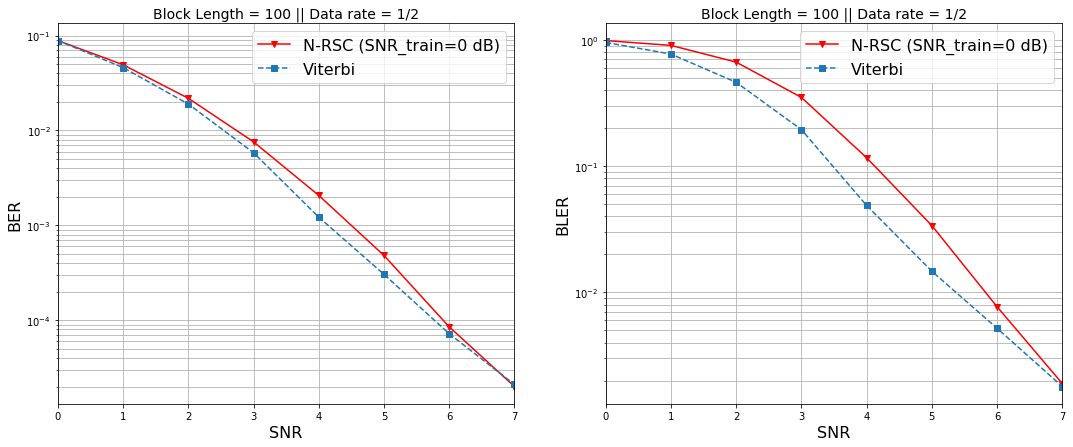

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
# ###################################
# Plot Bit Error Rate (BER) Curve
# ###################################
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(SNRs, neuralBERs, '-vr')
plt.semilogy(SNRs, viterbiBERs, 's--')
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=16)
plt.xlabel('SNR', fontsize=16)
plt.xlim(xmin=SNRs[0], xmax=SNRs[-1])  # this line
plt.ylabel('BER', fontsize=16)
plt.grid(True, which='both')
plt.savefig('result_ber_block_length_1000_snr0.png')

# ###################################
# Plot Block Error Rate (BLER) Curve
# ###################################
plt.subplot(1, 2, 2)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(SNRs, neuralBLERs, '-vr')
plt.semilogy(SNRs, viterbiBLERs, 's--')
plt.ylabel('BLER', fontsize=16)
plt.xlabel('SNR', fontsize=16)
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=16)

plt.xlim(xmin=SNRs[0], xmax=SNRs[-1])  # this line
plt.grid(True, which='both')
plt.savefig('result_bler_block_length_1000_snr0.png')